# AI 모델 2
### 이번 장은 가공된 데이터를 ARIMA 모델을 통해 예측해보는 과정입니다.
### ARIMA 모델을 사용한 AI 예측에 대한 학습을 건너뛰실 분은 이번 장을 건너뛰셔도 좋습니다.

## 목차
1. ARIMA 모델 불러오기
1. ARIMA 모델 소개
1. ARIMA 모델 선정
1. 학습
1. 결과 평가

## 1. ARIMA 모델 불러오기

### Step 1. statsmodels 라이브러리 설치

statsmodels를 pip을 통해 설치할 것입니다.  
pip은 파이썬의 여러 패키지를 관리해주는 도구입니다.  
본래는 터미널을 통해 불러와야하지만 '!'을 통해 jupyter에서도 호출할 수 있습니다.  
아래를 통해 statsmodels를 설치합니다.  
설치를 위해선 충분한 메모리와 CPU가 뒷받침 돼야 합니다.

In [1]:
!pip install statsmodels

Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 9.5 MB 94.7 MB/s eta 0:00:01 0:00:01
     |████████████████████████████████| 231 kB 81.9 MB/s eta 0:00:01��█████████████     | 194 kB 81.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


설치가 정상적으로 완료 되었다면 아래처럼 라이브러리를 호출할 수 있습니다.  
statsmodels.tsa.arima_model의 ARIMA를 호출합니다.

In [2]:
from statsmodels.tsa.arima_model import ARIMA

이제 우리가 사용해왔던 라이브러리와 데이터를 불러옵니다.

#### (실습 1) aicentro.session.Session, aicentro.framework.keras.Keras, numpy, pandas 라이브러리를 import하고 "data_2.csv"를 불러옵시다.

In [1]:
# Hint : 이번엔 header=None을 제외하고 불러옵니다.
from aicentro.session import Session
from aicentro.framework.keras import Keras as AiduFrm
import numpy as np
import pandas as pd
aidu_session = Session(verify=False)
aidu_framework = AiduFrm(session=aidu_session)
data = pd.read_csv("data_2.csv")

## 2. ARIMA 모델 소개

### Step 1. AR, MA 모델과 시계열 데이터

ARIMA 모델에 대해 이해하기 전에 시계열 데이터에 대해 짧게 설명하겠습니다.  
시계열 데이터는 기온, 수온, 인구수와 같이 시간의 흐름에 영향을 받는 데이터입니다.  
그렇지 않은 데이터는 지역별 인구수 차이, 기온 차이와 같은 데이터들이 있습니다.  
전통적으로 시계열 데이터는 규칙성 패턴과 불규칙성 패턴, 그리고 편차의 합으로 다뤄왔습니다.  
이중 이전 값의 영향을 받는다는 자기상관(Autocorrelation) 모형과 전체적을 편향성을 다루는 이동평균(MoveAverage)모델, 그리고 그 둘의 합을 다루는 모델들로 구분됩니다.  
간단하게 AR 모델과 MA 모델에 대해 알아봅시다.  

#### (실습 2) 시계열 데이터를 다루는 AR모델과 MA 모델에 대해 알아봅시다.

<pre>
# Hint : AR 모델의 핵심은 이전 값과 다음 값의 관계, MA 모델의 핵심은 이전 값들의 경향성입니다.
AR 모델 : 이전 값이 다음 값에 영향을 주고 결과적으로 평균적인 값이 일정할 것이라는 생각에서 발달한 모델입니다.
    이 때 이전 값은 직전 값일 수도 있지만 이전까지 p개, 혹은 전체를 포함할 수 있습니다.
    X(t) = (a*X(t-1) + c) + u*e(t)와 같은 식을 예로 들 수 있습니다.
    a, c, u는 특정한 상수입니다.
    살펴보면 이전 값, X에 영향을 받고 있는 것을 알 수 있습니다.
    
MA 모델 : 어떤 값이 지속적으로 증가하거나 감소하는 경향을 가질 것이라는 생각에서 발달한 모델입니다.
    이 때 이전 값은 직전 값일 수도 있지만 이전까지 q개, 혹은 전체를 포함할 수 있습니다.
    X(t) = (a*e(t-1) + c) + u*e(t)와 같은 식을 예로 들 수 있습니다.
    a, c, u는 특정한 상수입니다.
    살펴보면 이전 X값 보다는 에러, e값의 영향을 받는다는 것입니다.
</pre>

### Step 2. ARIMA 모델의 특징

AR과 MA 모델을 합친 ARMA 모델이 있습니다.  
ARMA 모델은 AR 모델에서 평균이 이동할 수 있다는 가정을 더한 모델입니다.  
ARMA 모델에서 중요하게 다루는 것은 상관관계가 크면 값이 클 때 함께 크고 작을 때 함께 작다는 것입니다.  
하지만 ARIMA 모델은 추세를 중요하게 다룹니다.  
값의 증감의 상관관계를 다뤄 이전 값에 비해 증가할 때 함께 증가하고, 감소할 때 함께 감소한다는 것입니다.  
가장 간단한 식으로는 a * (X(t) - X(t-1)) = b * X(t-1) + c * e(t-1) + d + u * e(t)이 있습니다.
ARIMA(p, d, q)로 주로 나타내는데 위 식은 ARIMA(1, 1, 1)을 표현하고 있습니다.  
여기서 p, d, q는 식을 결정하는 데 쓰이는 수로써 모수라고 합니다.  
이 수는 ACF, PACF를 계산하여 얻을 수 있습니다.  
이번 장에는 이에 대해 자세한 설명 보다는 간단하게 모수를 결정하는 법을 알아보고 학습에 사용해 볼 것입니다.

## 3. 모델 선정

### Step 1 데이터 정리

우선 우리가 가져온 데이터를 살펴봅시다.

In [3]:
data

,date,dev,val
0,20190101,2,29.0
1,20190102,2,32.0
2,20190103,2,29.0
3,20190104,2,23.0
4,20190105,2,46.0
...,...,...,...
325,20191126,2,13.0
326,20191127,2,9.0
327,20191128,2,12.0
328,20191129,2,11.0


이 중 dev열은 장비 2번을 사용했다는 의미를 갖고 있지만, 이번 학습 중에는 모든 데이터가 동일한 장비에서 가져온 데이터이므로 의미가 없을 것입니다.  
해당 열을 제외하도록 합시다.

#### (실습 3) dev열을 data에서 제외해봅시다.

In [4]:
# Hint : 이전엔 열 이름이 1, 2, 3과 같은 숫자였지만 이번엔 dev입니다.
data_dropped = data.drop('dev', axis='columns')
data_dropped

,date,val
0,20190101,29.0
1,20190102,32.0
2,20190103,29.0
3,20190104,23.0
4,20190105,46.0
...,...,...
325,20191126,13.0
326,20191127,9.0
327,20191128,12.0
328,20191129,11.0


이제 date열을 살펴봅시다.  
date열은 이름은 date이지만 실제론 어떨까요?  
info()를 통해 확인해보면 실제론 정수로 취급되고 있음을 알 수 있습니다.  
이제 이 값을 python에서 사용하는 datetime의 "연월일" 형식으로 바꿔봅시다.  
그리고 set_index()함수를 통해 date열을 DataFrame의 index로 설정할 수 있습니다.

In [5]:
import datetime

data_dropped['date'] = pd.to_datetime(data_dropped['date'],format='%Y%m%d')
data_dropped = data_dropped.set_index('date')
data_dropped

,val
date,
2019-01-01,29.0
2019-01-02,32.0
2019-01-03,29.0
2019-01-04,23.0
2019-01-05,46.0
...,...
2019-11-26,13.0
2019-11-27,9.0
2019-11-28,12.0


### Step 2 데이터 분리

이제 데이터를 학습을 위한 데이터, 예측 후 비교를 위한 데이터로 나눠봅시다.  
우리는 1월부터 10월까지의 데이터로 학습을, 11월의 데이터를 평가를 위한 데이터로 사용할 것입니다.  
DataFrame의 loc[]와 datetime.datetime()을 사용해 2019년 11월 1일 전후로 데이터를 나눠봅니다.

#### (실습 4) 앞서 정리한 데이터를 2019.01.01 ~ 2019.10.31과 2019.11.01 ~ 2019.11.30의 두 데이터로 분리합니다.

In [6]:
# Hint : Python의 배열에서 ':'를 다루는 방법을 사용합니다.
train = data_dropped.loc[:datetime.datetime(2019,10,31),:]
test = data_dropped.loc[datetime.datetime(2019,11,1):,:]
train

,val
date,
2019-01-01,29.0
2019-01-02,32.0
2019-01-03,29.0
2019-01-04,23.0
2019-01-05,46.0
...,...
2019-10-27,10.0
2019-10-28,8.0
2019-10-29,21.0


### Step 3. 모델 생성

모델을 생성하기 전 앞서 말했던 모수를 추정해봅시다.<br>
저희는 보편적으로 좋은 데이터를 갖는 2, 1, 2를 사용하겠습니다.

#### (실습 5) ARIMA 모델의 생성 전 변수를 p, d, q에 결정합니다.

In [44]:
# Hint : 값은 바꿔서 다시 학습해도 됩니다.
p = 2
d = 1
q = 2

## 4. 학습

### Step 1. 모델을 통한 학습

#### (실습 6) 모델을 생성하고 학습합니다.

In [45]:
# Hint : ARIMA(학습할 데이터, (p, d, q))로 모델을 생성할 수 있습니다.
# Hint : 모델의 학습은 fit()을 사용합니다.
model_new = ARIMA(train,(p,d,q))
model_fit = model_new.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### (실습 7) 모델을 통해 test 기간에 맞게 예측해봅니다.

In [46]:
# Hint : 학습된 결과에 forecast()를 사용합니다. 이 떄 인수로 steps에 일 수를 지정해줍니다.
full_forecast = model_fit.forecast(steps=test.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=test.index, columns = test.columns)

## 5. 결과 평가

### Step 1. DataFrame을 통한 데이터 비교

이제 데이터가 잘 예측되었는지 확인해봅시다.  
DataFrame으로 예측된 데이터를 확인할 수 있습니다.  
각 열의 의미를 파악하며 데이터가 얼마나 정확하게 예측했는지 봅시다.

### Step 2. 그래프

데이터를 비교하는 다른 방법은 그래프로 이를 그려보는 것입니다.  
우리는 matplotlib을 통해 이 과정을 수행할 수 있습니다.  

#### (실습 8) Matplotlib 혹은 Seaborn 등의 그래프 라이브러리를 import해 그래프를 그려봅니다.

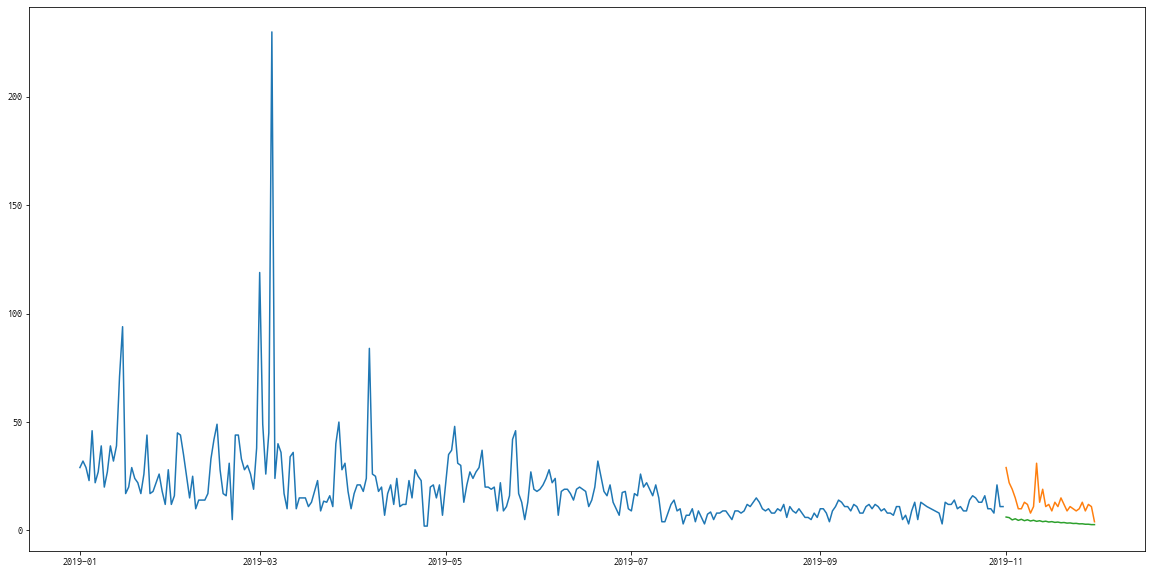

In [47]:
# Hint : 그래프가 작다면 크기를 늘릴 수 있습니다.
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(train)
plt.plot(test)
plt.plot(forecast)

### Step 3. 결과 분석
학습을 시키는 것만큼이나 결과를 분석하는 것도 중요합니다.  
저의 경우는 값의 평균값 근처에서 예측한 것으로 보입니다.  
아마 경향성, 이전 값에 대한 영향을 고려함에도 1년에 해당하는 데이터를 입력하지 않았던 점, 다시 말해 데이터가 불충분했기 때문으로 보입니다.  
그 외에도 모델의 적합성, 모수에 따른 차이 등을 들 수 있을 겁니다.  
#### (실습 9) 학습을 향상시키려면 어떤 방법이 있을지 생각해봅니다.

In [ ]:
1. 모수 재설정